<img src="https://support.datascientest.com/uploads/default/original/1X/6bad50418375cccbef7747460d7e86b457dc4eef.png" alt="image info" />


# Rapport technique

**Participants** : Olga TOLSTOLUTSKA, Mohamed BACHKAT, Charly LAGRESLE \
**Mentor** : Manu PORTEL \
**Promotion** : DST Bootcamp DEC22 \
**Date du document** : 2023/03/06



# Introduction

## Contexte et objectifs

### Contexte

Rakuten est un site de e-commerce, regroupant près de 1.3 milliards d'utilisateurs. Afin de faciliter la gestion des suggestions de leurs recherches ou des recommandations qui leurs seront proposées, il est important de classifier les produits. Du fait de la quantité de produits et de leurs catégories associées, ce classement ne peut ni être fait manuellement, ni être régi par des règles. Une approche plus flexible, efficace et reproductible est donc à mettre en place. 

### Objectif

L'objectif est de prédire le code de chaque produit, c'est-à-dire sa catégorie, sur la base d'une analyse de données textuelles et d'images.

### Étapes du projet

Le déroulement du projet suit la statégie suivante :

* Analyse exploratoire
    * Prise en main des données
    * Analyse statistique et feature-engineering
    * Choix des métriques
* Conception de modèles de référence en machine learning
* Conception de modèles deep-learning
    * Traitement des images et du texte
    * Fusion de modèles
* Développement d'un outil intercatif

Le rapport ici présent se compose de parties similaires à ce plan.

In [834]:
from IPython.display import Image
import pandas as pd

def make_pretty(styler, limits=[0, 1],fmt="{:.3f}", cmap="RdYlGn"):
    styler.format(fmt)
    styler.background_gradient(axis=None, vmin=limits[0], vmax=limits[1], cmap=cmap)
    return styler

def make_smaller():
    heading_properties = [('font-weitgh', 'bold'), ('font-size', '10px') ]
    cell_properties = [('font-size', '9px')]

    return [dict(selector="th", props=heading_properties), dict(selector="td", props=cell_properties)]

# Analyse exploratoire

L'exploration des données est la première étape de ce projet. Cette dernière permet de se familiarier avec le jeu de données, d'en comprendre la structure, les particularités et d'anticiper les actions à mettre en place pour extraire, transformer et traiter ces données.

## Prise en main des données

Les données fournies pour ce challenge sont les suivantes :
* `X_train_update.csv` : données explicatives et textuelles pour l'entraînement
* `X_test_update.csv` : données explicatives et textuelles pour les tests
* `Y_train_CVw08PX.csv` : variable cible pour l'entraînement
* `images/image_train/*.jpg` : images pour l'entraînement
* `images/image_test/*.jpg` :  images pour les tests

> Nous notons que la varible cible de test n'est pas fournie : les observations de tests ne seront donc pas exploitées.

Le jeu d'entrainement se compose a priori de 84 916 observations : des données textuelles ainsi que des images.

### Données d'entrées

Deux types de données d'entrées sont à notre disposition : des textes et des images. Nous analysons chacun de ces types de données séparemment.

#### Textes

Les données `X_train_update.csv` se compose de plusieurs champs : 

* `designation` : titre du produit dans différentes langues (0% de NaNs)
* `description` : description détaillée du produit dans différentes langues (35% de NaNs)
* `productid` : identifiant unique du produit (0% NaNs)
* `imageid` identifiant unique de l'image du produit (0% NaNs)

> Les champs `productid` et `imageid` ne servent qu'à construire le nom du fichier image associé au produit. Ils ne seront donc pas étudiés statistiquement parlant.

Près de 35% des observations de la colonnes `description` est manquant : cette colonne sera par la suite fusionnée avec la colonne `designation`, ce qui rendra nul le nombre de NaNs de cette nouvelle colonne.

#### Images

Chaque produit est associé à une image qui le représente. L'image comporte le produit, généralement photographié sur un fond blanc, mais peut également être complété par une mise scène du produit (jardin, décoration) ou par un support (main portant le produit par exemple). Les images sont en couleur, ont une taille de 500x500 pixels et nous sont fournies au format `.jpg`.

### Données de sorties

Les cibles sont fournies dans le fichier `Y_train_CVw08PX.csv`. À ce stade, nous nous contentons de noter que 27 catégories différentes seront à déterminer.

### Analyse du problème

#### Type de problème

Les observations textuelles et graphiques doivent permettre au modèle d'affecter à chaque observation dont les features sont actuellement (`designation`, `description` , et une image) à une catégorie de produit `prdtypecode`. Cette cible est disponible et se présente sous la forme d'un numéro associé à une catégorie (par exemple `livre`, `tech`, `décoration`, etc.).

Nous avons donc affaire à un problème de catégorisation supervisé. Pour la partie texte, un analyse automatique du langage naturel (*NLP : Natural Langage Processing*) sera à mettre en place.

#### Particularité du problème

La catégorisation se base sur l'apprentissage fait sur les données à notre disposition. Ces données sont de deux types (textuel et graphique). De ce fait :
* les pré-traitements seront différents
* plusieurs modèles seront à concevoir, à entrainer et à faire dialoguer
    * un modèle pour catégoriser le produit en fonction du texte fourni
    * un modèle pour catégrosier le produit en fonction de son image associée
    * une étape de regroupement des prédictions sera à réaliser afin d'obtenir une unique catégorie en fin de process


## Analayse statistique et feature-engineering

Maintenant que la structure des données est connue, l'étape suivante est d'analyser plus en profondeur les données, d'en créer de nouvelle et de préparer le dataset à son entraînement. Ces étapes de feature-engineering sont détaillées dans les prochains paragraphes. 

### Données d'entrée : textes

L'analyse exploratoire et statistiques de données textuelles nécessite que des données complémentaires soient calculées pour caractériser numériquement nos textes.

#### Nombre de mots

Pour `designation`, les textes sont composés de 4 à 54 mots. La répartition est de type gaussienne : la moyenne se situe à 11.5 mots et l'écart-type est de 6.4 mots. 75% des textes de `designation` ont moins de 14 mots. 

Pour `description`, les textes plus longs et comportent entre 0 (certaines descriptions sont vides) et 2 068 mots. En moyenne, la description se compose d'un texte de 78 mots et 75% des produits sont décrits avec moins de 124 mots. La répartition du nombre de mots suit ici la densité de probabilité d'une loi exponentielle.

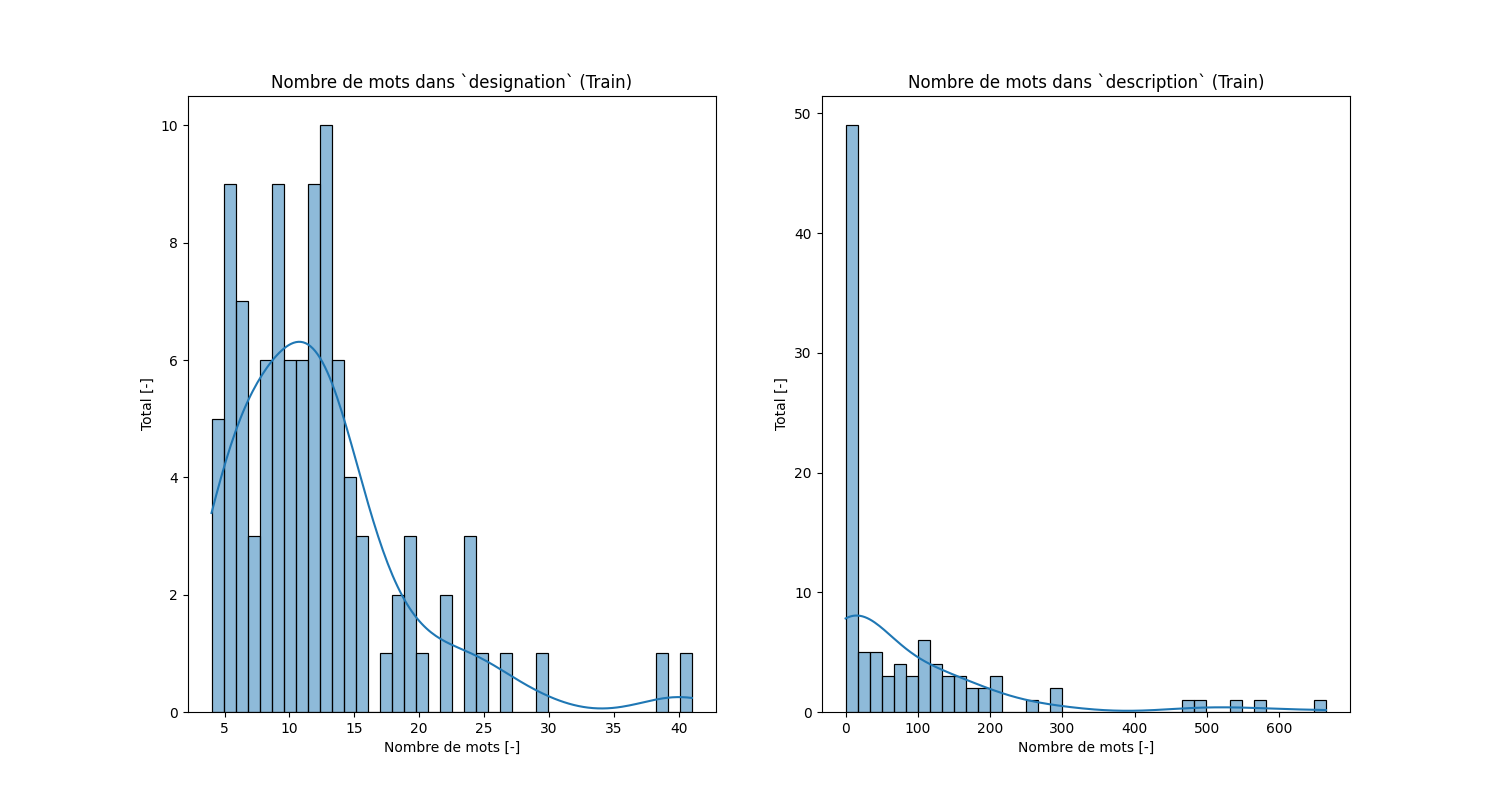

In [835]:
Image(filename="images/words.png", width=800)



Plusieurs actions seront mises en place suite à cette étude

* Les colonnes `designation` et `description` seront fusionnées en une seule colonne `text`
* La colonne `text` sera limitée à 500 mots.    


#### Langues

Intéressons-nous maintenant à la langue. Les colonnes `designation` et `description` contiennent du texte dont la langue peut varier. Le graphique ci-dessous montre la répartition des langues pour la colonne `designation`. La répartition des langues est très hétérogène :
* 81% en français
* 14% en anglais
* 1.5% en allemand
* inférieurs à 1.5% : nl, ca, it, ro, pt, etc...

Le choix a été fait de traduire les textes étrangers vers le français.

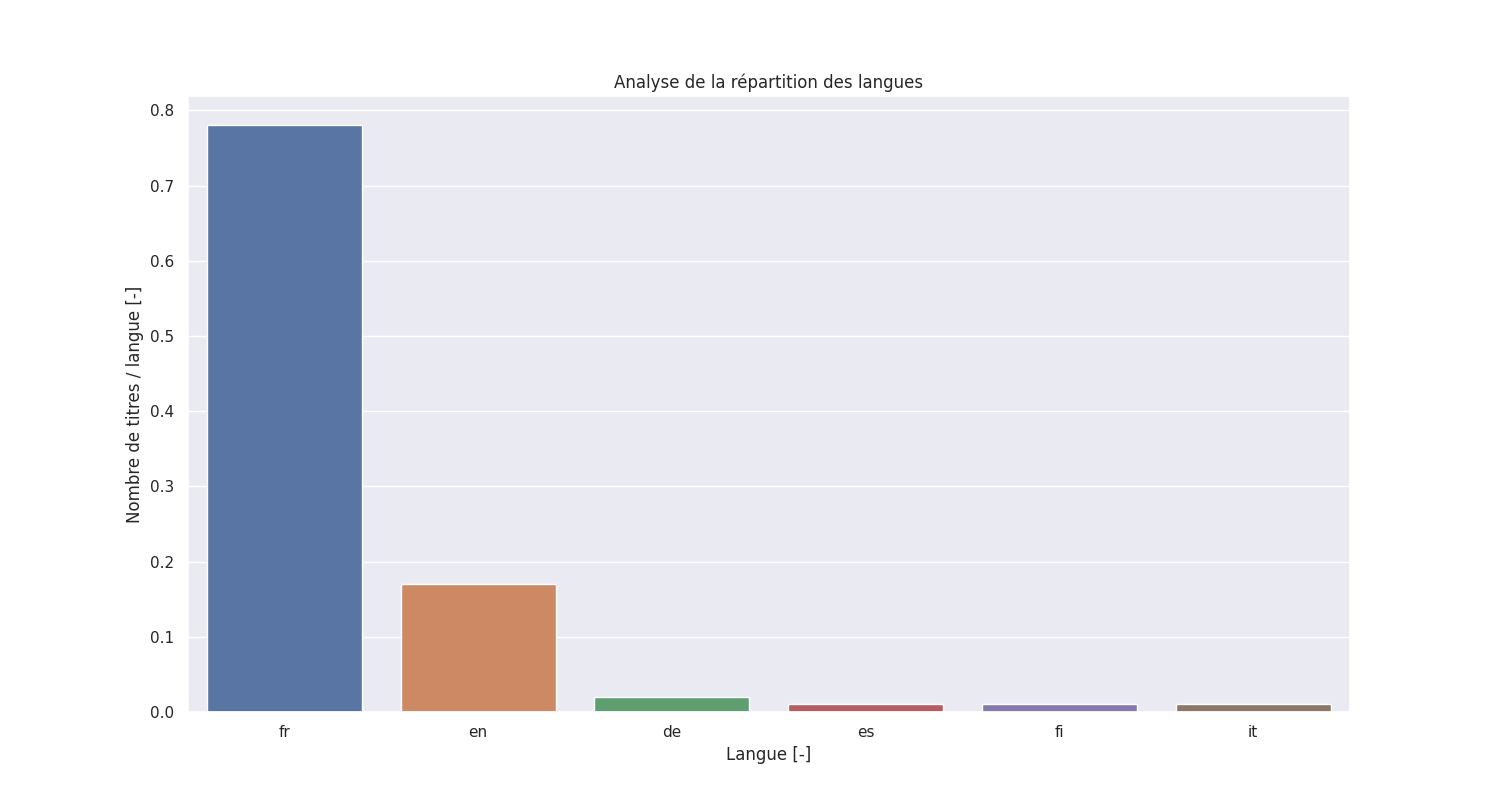

In [836]:
Image(filename="images/lang.png", width=700)

### Données d'entrée : images

#### Réduction de dimension

Nous avons noté que beaucoup d'images sont photographiées sur un fond blanc. Ce fond n'apporte en soi aucune information et peut mener à un biais dans notre modèle de classification des images.

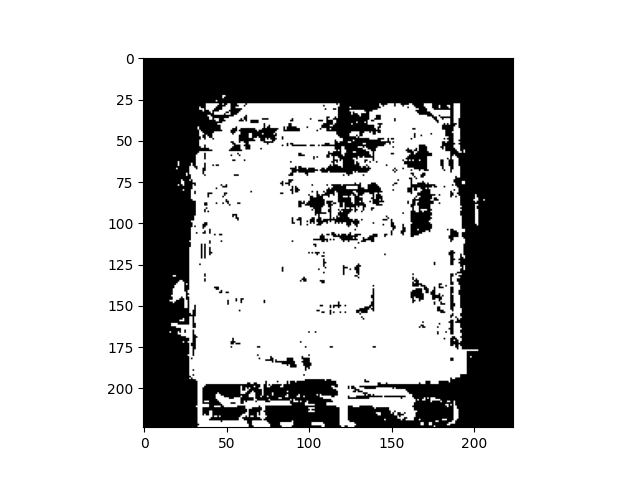

In [837]:
Image(filename="images/mask.png", width=400)


En faisant une analyse de la variance des pixels sur un échantillon d'images, nous notons que les bordures des images présentent une variance très basses. 

Les images pourront être rognées de 20% pour supprimer ces marges porteuses de peu d'information avant d'être redimensionnées à la dimension souhaitée.

### Données de sorties

Commme expliqué précédemment, 27 catégories sont présentes dans notre dataset. La figure ci-dessous présente sur 84 916 pixels les catégories en nuance de gris : aucun patern n'émerge visuellement, le dataset d'origine semble être déjà randomisé.

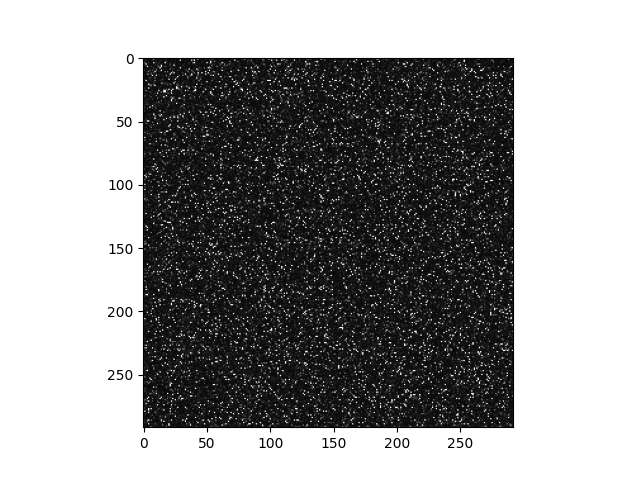

In [838]:
Image(filename="images/random_targets.png", width=400)


#### Déséquilibre

Le graphique ci-dessous montre le nombre de produits pour chacune des 27 catégories. On remarque facilement que la catégorie "Aquatique" est sur-représentée : elle comporte le double de produits par rapport à la catégorie suivante. On observe également une baisse linéaire du nombre de produits de `Affiche` vers `Accessoire console`. Les catégories de `Cuisine` à `Jeu PC` ne présentent que peu d'individus. 

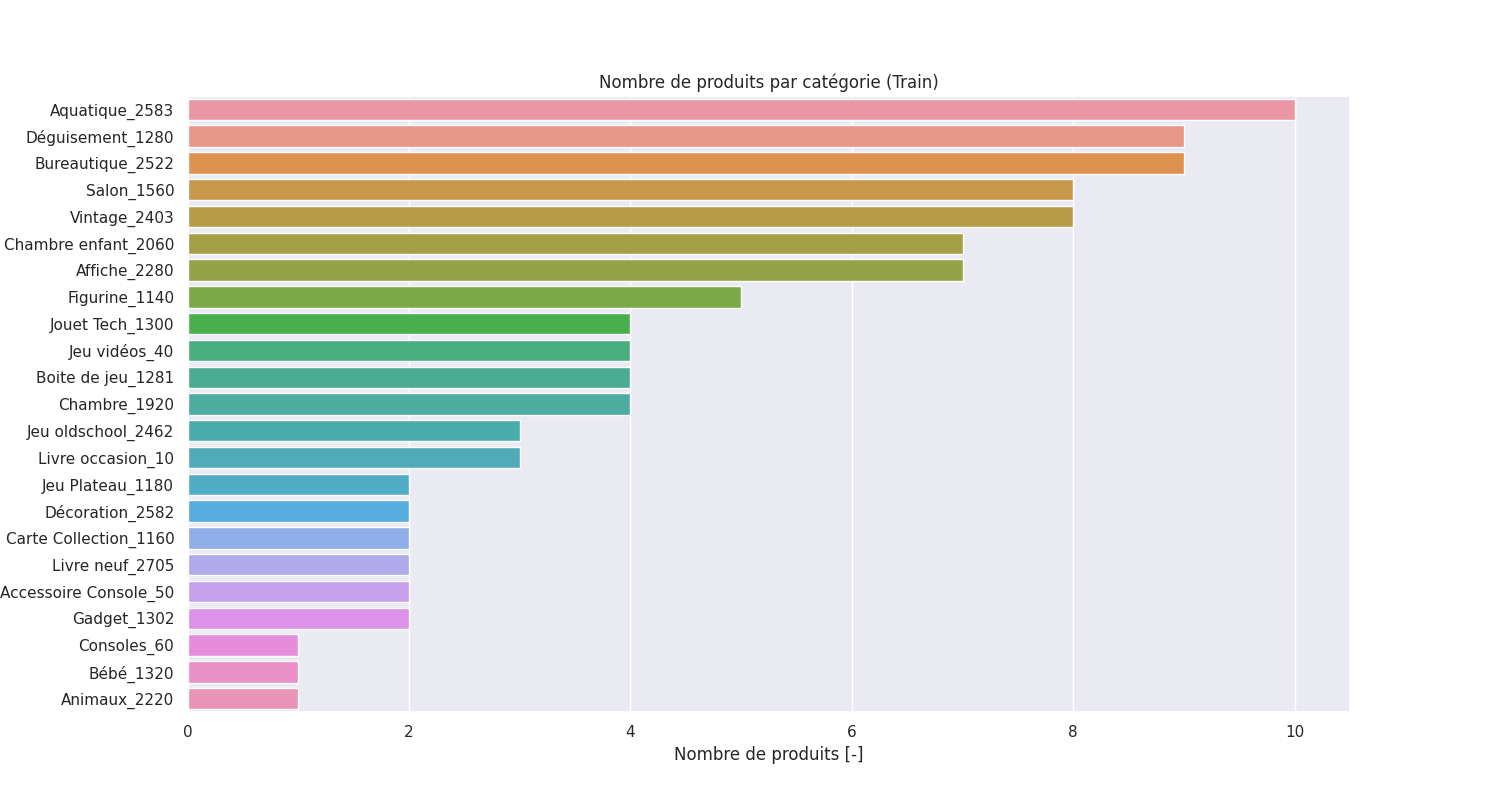

In [839]:
Image(filename="images/imbalanced.png", width=800)

#### Catégories

L'analyse visuelle de quelques produits pour chaque catégorie nous permet d'une part de traduire le numéro de catégorie en une variable plus compréhensieble et d'autre part d'étudier la constitution de chacune d'entre elles. Cette analyse a été faite sur toutes les catégories, voici ci-dessous un exemple pour les 10 premières d'entre elles.

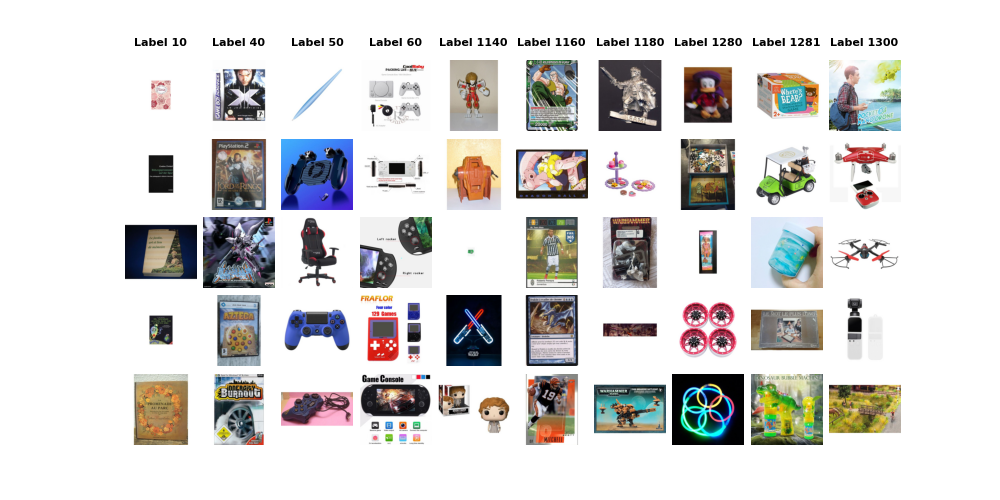

In [840]:
Image(filename="images/images_category.png", width=1200)

Les catégories et leurs descriptions sont proposées dans le tableau suivant.

<table style="margin-left: auto;
            margin-right: auto;
            font-size:10px;
            border: 7px dashed white;
            border-radius: 10px">

<tr><td>

|Numéro de catégorie| Description|
|-------------------|------------|
| 10 | Livre d'occasion |
| 40 | Jeu Console |
| 50 | Accessoire Console|
| 60 | Tech |
| 1140 | Figurine |
| 1160 | Carte Collection |
| 1180 | Jeu Plateau |
| 1280 | Déguisement |
| 1281 | Boite de jeu |
| 1300 | Jouet Tech |

</td><td>

|Numéro de catégorie| Description|
|-------------------|------------|
| 1301 | Chaussette |
| 1302 | Gadget |
| 1320 | Bébé |
| 1560 | Salon |
| 1920 | Chambre |
| 1940 | Cuisine |
| 2060 | Chambre enfant |
| 2220 | Animaux |
| 2280 | Affiche |
| 2403 | Revue |

</td></td> 

</td><td>

|Numéro de catégorie| Description|
|-------------------|------------|
| 2462 | Jeu oldschool |
| 2522 | Bureautique |
| 2582 | Décoration |
| 2583 | Aquatique |
| 2585 | Soin et Bricolage |
| 2705 | Livre neuf |
| 2905 | Jeu PC |
|<br/> | |
|<br/> | |
|<br/> | |
</td></tr>

</table>

<div>
<div style="margin-left: auto;
            margin-right: auto;
            font-size:      10px;
            width: 30%">
            




</div>
</div>


Certains catégories ont été délicates à définir, car présentant de très fortes similitudes avec d'autres. Des catégories plus larges pourraient être identifiées. C'est par exemple le cas pour :

* Gaming : jeu PC et jeu Console
* Lecture : livre neuf et livre d'occasion
* Jeu : figurine, jeu oldschool et jeu manuel

Les algorithmes de classification éprouveront probablement les mêmes difficultées à distinguer les produits à l'intérieur de ces catégories plus étendues.


## Choix des métriques

Afin de pouvoir qualifier la performance de nos modèles, le choix de la métrique est important. Les notions importantes avant de considérer le choix de la métrique sont les suivantes :

* connaissance métier : ici, nous catégorisons des produits sur un site de vente et faire une erreur de catégorie n'est pas fatidique, l'erreur peut être corrigée.
* jeu de données déséquilibré : nous n'avons pas d'informations sur l'origine de ce déséquilibre. Une catégorie sur-représentée présente-elle les produits les plus vendus ou  les produits les plus souvent mal classés?
* forte tendance à l'overfitting
* une erreur de catégorie n'est pas dramatique

Notre choix se porte sur le *weighted f1-score*, qui considère le déséquilibrage du dataset et fournit un bon compromis entre le *recall* et l'*accuracy*.

Enfin, deux informations complémentaires relatives à la comparaison des modèles:
* 27 catégories sont à notre disposition. Cela signifie qu'un score de plus de 3.7% est d'ores et déjà supérieur à un modèle purement aléatoire.
* afin de garantir une reproductibilité des résultats, les échantillons d'entrainement et de tests sont pour tous les modèles similaires, avec un *random_state* fixée à 123.


### Prévention de l'overfitting

Les modèles implémentés sont sensibles à l'*overfitting*. Afin de minimiser au maximum ce risque, plusieurs actions ont été mises en place :
* suivi de l'évolution des métriques d'apprentissage via *Tensorboard*
   * 
* ajout des couches `Dropout` dans nos architectures
* augmentation nos données
* simplification l'architecture des modèles
* utilisation de batches de petite taille
* application d'une cross-validation à 3 échantillons :
    * le modèle est fit sur les données *train*
    * à chaque époque, son évalution est faite sur les données *validation*
    * une fois l'entraînement terminé, le modèle est ensuite globalement étudié sur les données *test*
* appel à des callbacks

Les callbacks sont utiles pour contrôler le déroulement de l'apprentissage. Nous avons mis en place deux méthodes de gestion de l'apprentissage :
* `EarlyStopping` : met fin à l'apprentissage si `val_loss` augmente pendant plus de 5 périodes à partir de la 8ème période
* `ReduceLROnPlateau` : réduit le taux d'apprentissage si `val_loss` stagne sur un plateau pendant plus de 5 périodes

Finalement, le découpage du dataset pour l'entraînement et la prediction est le suivant : 

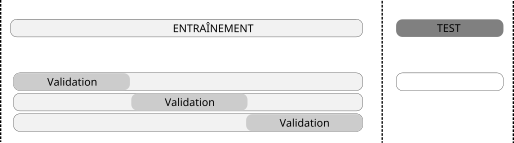

In [841]:
Image(filename="images/decoupage_dataset.png")

# Modèles de références

L'analyse exploratoire nous a permis de définir une stratégie pour le traitement du texte et des images. Des modèles de références simples sont mis en place pour catégoriser les produits en fonction des données textuelles et des images à notre disposition. Ces modèles simples se basent sur des techniques de *machine learning* et sur l'ensemble des données fournies.

## Textes

Les modèles de texte nécessitent un travail de preprocessing important. Une fois la méthodologie mise en place, des modèles de classification simple sont entraînés pour définir la catégorie du produit en fonction du texte dont nous disposons.

### Étapes de *preprocessing*


Les étapes suivantes sont éxécutées via des pipelines afin de transformer les données textuelles :

* calculer les longueurs des textes pour `designation` et `description`
* calculer le nombre de mots pour `designation` et `description`
* fusionner ces deux colonnes dans `text`
* détecter la langue dans `text`
* préparer la colonne `text` :
    * supprimer la ponctuation
    * supprimer les caractères spéciaux
    * supprimer les valeurs numériques
    * supprimer les majuscules
    * supprimer les balises html
    * supprimer les *stopwords*
    * extraire la racine des mots
    * vectorisation

**Extraction de la racine des mots** permet de fusionner des mots partageant la même racine et de regrouper leurs poids. Par exemple, les mots `marée`, `marin`, `maritime` sont basés sur le même radical `mar` (ou `mer`).

**Suppression des stopwords** qui sont des mots courament utilisés dans la langue choisie. En français, les mots `afin`, `elle`, `est`, `sur` en font par exemple partie : ils n'apportent peu ou pas d'informations. Cette étape a été maintenue en place bien que le `vectorizer` `tf-idf` aurait pénalisé ce genre de mots.

**Vectorisation** du texte via un `Tokenizer`. Ici est calculer l'importante du mot dans un texte. Nous n'utilisons pas le tokenizer en mode `counter` (le mot le plus important est le mot le plus fréquemment présent) mais en mode `tf-idf` pour *Term Frequency - Inverse Document Frequency*. La partie `TF` calcule la fréquence d'apprition d'un mot dans un texte alors que la partie `IDF` corrige ce premier terme en analysant la distribution d'un mot dans l'ensemble des documents. Ainsi, un mot apparaissant fréquemment dans quelques docuemnts seulement aura d'avantage de poids qu'un mot très fréquent dans tous les documents.

À la fin de cette étape de *preprocessing*, nous disposon d'un texte nettoyé. L'étape de vectorisation varie en fonction du modèle utilisé par la suite.

### Modèles simples et résultats

Suite à l'application du preprocessing, à la séparation du dataset de texte, plusieurs algorithmes de machine learning ont été entraînés via crossvalidation et testés sur le dataset de test : 

* LogisticRegressionClassifier
* RandomForestClassifier
* DecisionTreeClassifier
* KNeighborsClassifier

La comparaison des résultats sur la métrique *weighted f1-score* est proposée ci-dessous:

In [842]:
df = pd.read_csv("../src/models/text/summary_f1-score.csv", index_col="Unnamed: 0")
columns_drop = df.columns[["neural" in column for column in df.columns]]
df.drop(columns_drop, axis=1, inplace=True)
df.columns = [column[5:] for column in df.columns]
df.drop(["accuracy", "macro avg"], axis=0, inplace=True)
df.rename({"weighted avg": "weighted F1-Score"}, axis=0, inplace=True)
df.style.pipe(make_pretty).set_table_styles(make_smaller())

,logistic_regression,random_forest,kneighbours,decision_tree
10,0.449,0.472,0.260,0.376
40,0.543,0.595,0.320,0.499
50,0.730,0.770,0.518,0.618
60,0.875,0.891,0.814,0.823
1140,0.670,0.685,0.530,0.586
1160,0.877,0.865,0.731,0.836
1180,0.391,0.475,0.381,0.420
1280,0.638,0.603,0.449,0.534
1281,0.507,0.482,0.322,0.410
1300,0.899,0.866,0.729,0.890


Pour les algorithmes de machine learning simples, sans recherche d'hyperparamètres idéaux, c'est le modèle *LogisticRegressionClassifier* qui obtient le meilleur *weighted f1-score* avec une valeur de 77.1%, juste avant le *RandomForestClassifier* avec son score de 76.0%. Nous notons que de manière générale, certaines classes sont mal catégorisées. Nous analysons ci-dessous les résultats de LogisticRegression :

* Catégorie `10` (Livre d'occasion) souvent confondue avec `2705` (Livre neuf) et `2403` (Revue) 
* Catégorie `40` (Jeu console) souvent confondue avec `10` (Livre occasion)  et `2462` (Jeu oldschool)
* Catégorie `1280` (Déguisement) souvent confondue avec `1281` (Boîte de jeu) et `1140` (Figurine)

La confusion apparaît souvent entre des produits du même type. Ce risque avait été évoqué lors de l'analyse exploratoire de nos données cibles : les produits se décrivent dans un vocabulaire similaire.

In [843]:

df = pd.read_csv("../src/models/text/text_logistic_regression/crosstab_report.csv", index_col="Realité")
df.style.pipe(make_pretty, limits=[0, 1], fmt="{:.02f}", cmap="Greys").set_table_styles(make_smaller())

,10,40,50,60,1140,1160,1180,1280,1281,1300,1301,1302,1320,1560,1920,1940,2060,2220,2280,2403,2462,2522,2582,2583,2585,2705,2905
Realité,,,,,,,,,,,,,,,,,,,,,,,,,,,
10,0.52,0.05,0.00,0.00,0.01,0.01,0.04,0.01,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.07,0.11,0.00,0.00,0.00,0.00,0.00,0.13,0.00
40,0.10,0.55,0.05,0.00,0.02,0.05,0.01,0.01,0.04,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00,0.02,0.01,0.06,0.00,0.00,0.00,0.00,0.02,0.00
50,0.00,0.05,0.73,0.02,0.01,0.00,0.00,0.02,0.01,0.01,0.00,0.00,0.01,0.01,0.00,0.00,0.01,0.00,0.00,0.00,0.07,0.01,0.01,0.00,0.01,0.00,0.01
60,0.00,0.02,0.03,0.86,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.00,0.00,0.00,0.00,0.01,0.00
1140,0.03,0.05,0.00,0.00,0.68,0.03,0.03,0.04,0.02,0.01,0.00,0.01,0.01,0.00,0.00,0.01,0.00,0.00,0.01,0.03,0.01,0.01,0.00,0.00,0.00,0.01,0.00
1160,0.03,0.01,0.00,0.00,0.01,0.89,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1180,0.10,0.04,0.02,0.00,0.07,0.02,0.50,0.03,0.06,0.00,0.01,0.02,0.01,0.00,0.00,0.01,0.01,0.00,0.01,0.03,0.01,0.01,0.01,0.00,0.00,0.03,0.01
1280,0.02,0.02,0.01,0.00,0.05,0.01,0.01,0.61,0.09,0.04,0.00,0.03,0.03,0.01,0.00,0.00,0.02,0.01,0.01,0.00,0.00,0.01,0.00,0.00,0.01,0.01,0.00
1281,0.03,0.03,0.01,0.01,0.03,0.02,0.02,0.17,0.51,0.00,0.01,0.04,0.01,0.00,0.00,0.00,0.02,0.00,0.01,0.01,0.01,0.02,0.01,0.00,0.01,0.03,0.00





## Images

#### Feature PCA  + Modèle SVC :

Dans une deuxième partie de l'étude de la modélisation par ML des images, il est opéré une SVC (avec une réduction de dimensions par PCA) car il est le modèle le plus efficace pour la reconnaissance de formes. Le score obtenu a été de 0.3. Ce score est différent de ceux d'Olga car les images sont plus nombreuses plus de 4000 images et ce qui est décisif c'est le paramètre du SVC, kernel = 'rbf'.Ce score médiocre n'est pas suffisant et un modèle plus avancé a été proposé qui est l'arbre de décision boosté. Olga qui a notamment travaillé sur les modèles de classification de ML a elle aussi obtenu des résultats non satisfaisants. Elle a quant à elle réalisé une cross validation avec des grilles et elle a travaillé sur les métriques.  En fait les modèles de classification de Machine learning ne sont pas assez puissants pour notre problèmatique de classification d'images et il faut passer au deep learning. 



La matrice de confusion en heatmap est la suivante :





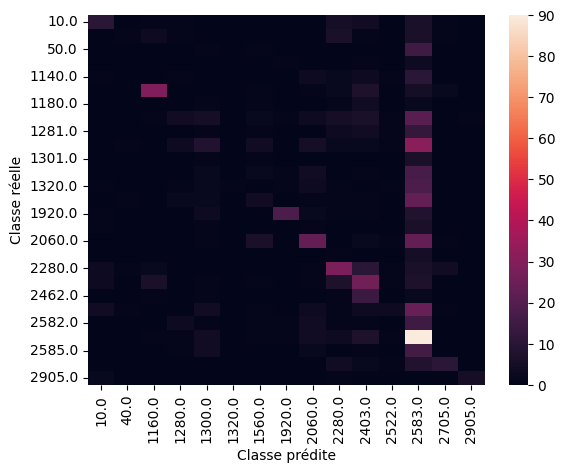

In [844]:
from IPython.display import Image
Image(filename="images/SVCHeatmap.png")

# Modèles de deep-learning

Dans la précédente partie, des techniques simples de modélisation ont été mises en place. Afin d'améliorer notre métrique *weighted f1-score*, des modèles de *deep-learning*, plus complexes et longs à entraîneer sont utilisés. Finalement, ces modèles seront fusionnés pour exploitier au mieux les performances de chacun d'entre eux.

## Textes

Les textes subissent la même étape de *preprocessing* que pour les modèles de *machine learning*.

### Modèle neuronal dense

Le modèle Neural_Simple se base sur la tokenisation *tfidf* de nos textes. Les entrées sur modèle sont donc une matrice représentant le score-tfidf de chaque mot de chaque texte, si ce mot est dans le vocabulaire de notre tokenizer.


| Layer (type)    |            Output Shape    |          Param |  
|-----------------|----------------------------|-----------------|
| text_dense_1 (Dense)|        (None, 54)     |           270054 |   
| text_drop_1 (Dropout) |      (None, 54)     |           0       |  
| text_output (Dense)|        (None, 27)      |          1485    |  
                                                                 
Total params: 271,539 \
Trainable params: 271,539 \
Non-trainable params: 0 

### Modèle neuronal embedding 

Le modèle *Neural_Embedder*, a la particularité de présenter une couche d'embedding qui nous permet de fournir directement un ensemble de mots à ce réseau de neurones. La vectorisation pour ce réseau gère 50 000 mots et seuls les 500 plus fréquents sont conservés. 

| Layer (type)        |         Output Shape    |           Param |   
|-----------------------|----------------------|--------------------| 
| text_input (Embedding) |      (None, None, 100) |         5000000 |   
| text_average (GlobalAverage Pooling1D) |  (None, 100)      |         0         | 
| text_drop_1 (Dropout)   |    (None, 100)     |          0    |      
| text_dense_1 (Dense)     |   (None, 54)     |           5454   |    
| text_drop_2 (Dropout)   |    (None, 54)     |           0    |      
| text_output (Dense)     |    (None, 27)      |          1485   |    
                                                                 

Total params: 5,006,939 \
Trainable params: 5,006,939 \
Non-trainable params: 0 

Pour ce modèle, cette couche est conçue via un le tokenizer de keras.


In [845]:
df = pd.read_csv("../src/models/text/summary_f1-score.csv", index_col="Unnamed: 0")
columns_drop = df.columns[["neural" not in column for column in df.columns]]
df.drop(columns_drop, axis=1, inplace=True)
df.columns = [column[5:] for column in df.columns]
df.drop(["accuracy", "macro avg"], axis=0, inplace=True)
df.rename({"weighted avg": "weighted F1-Score"}, axis=0, inplace=True)
df.style.pipe(make_pretty).set_table_styles(make_smaller())

,neural_simple,neural_embedding
10,0.486,0.529
40,0.575,0.582
50,0.795,0.800
60,0.872,0.905
1140,0.707,0.696
1160,0.892,0.934
1180,0.445,0.347
1280,0.648,0.610
1281,0.549,0.540
1300,0.906,0.934


Les *weighted f1-score* obtenus par ces modèles de *deep learning* sont meilleurs que ceux de *machine learning*. Ici, le modèle avec la couche *embedding* est de 3 points plus performant que le modèle *LogisticRegressionClassifier*. Les produits propices aux erreurs de classification sont en revanche similaires et ce pour les mêmes raisons.




## Images

### Modèle CNN

### Modèle VGG16




In [851]:
df = pd.read_csv("../src/models/image/summary_f1-score.csv", index_col="Unnamed: 0")
columns_drop = df.columns[["cnn" in column for column in df.columns]]
df.drop(columns_drop, axis=1, inplace=True)
df.columns = [column[6:] for column in df.columns]
df.drop(["accuracy", "macro avg"], axis=0, inplace=True)
df.rename({"weighted avg": "weighted F1-Score"}, axis=0, inplace=True)
df.style.pipe(make_pretty).set_table_styles(make_smaller())

,CNN_Lenet,CNN_Lenet_charly,CNN_Lenet_224
10,0.000,0.325,0.000
40,0.000,0.261,0.000
50,0.000,0.019,0.000
60,0.000,0.014,0.000
1140,0.000,0.012,0.000
1160,0.000,0.000,0.000
1180,0.000,0.012,0.000
1280,0.000,0.000,0.000
1281,0.000,0.028,0.000
1300,0.000,0.000,0.000


In [852]:
df = pd.read_csv("../src/models/image/image_CNN_Lenet_224/crosstab_report.csv", index_col="Realité")
df.style.pipe(make_pretty, limits=[0, 1], fmt="{:.02f}", cmap="Greys").set_table_styles(make_smaller())

,1160,1301,2280,2582
Realité,,,,
1560,1.00,0.00,0.00,0.00
2280,0.00,1.00,0.00,0.00
2522,0.00,0.00,0.00,1.00
2705,0.00,0.00,1.00,0.00


## Fusion des modèles images et textes

Les deux modèles peuvent fonctionner indépendemment. Cependant, il est possible de mutualiser leurs capacités en fusionnant ces deux modèles en un unique modèle de classification.

### Fusion par concaténation de couches

La fusion est mise en place par concaténation de couches du modèle de texte et du modèle d'image. Cette concaténation est faite sur les avant-dernières couches de nos modèles : ces couches comportent un maximum d'informations. Les autres couches des modèles pré-entrainés sont quant à elles *freezées*. Des couches denses sont ajoutées suite à la concaténation pour obtenir une classification sur 27 classes. Ci-dessous, un graphique simplifié du fonctionnement de cette concaténation.

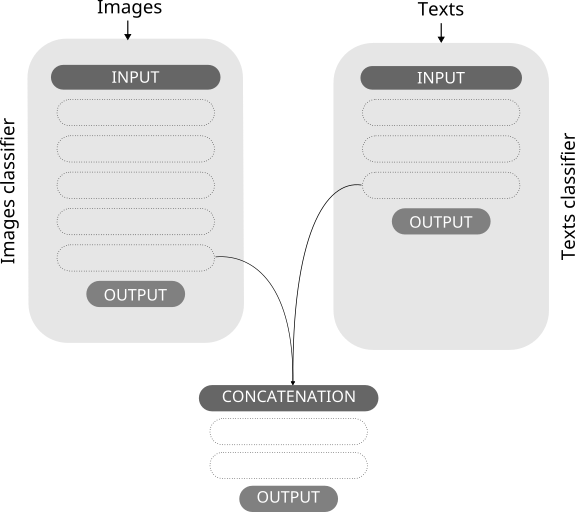

In [848]:
Image(filename="images/fusion_methodology.png", width=500)

En appliquant cette méthode à nos modèles `text_neural_embedding` et `image_vgg16`, près de 15 millions de paramètres ne sont plus à entraîner. La concaténation a bien lieu au niveau des couches précédant les couches denses de classication.

| Layer (type)         |          Output Shape     |    Param #   |  Connected to      |  
|-|-|-|-|             
| vgg16_input  |     [(None, None, None,3)] |  0          | []      |                         
|vgg16_image_CNN_Lenet_1 | (None, None, None,512)  | 14714688  | ['vgg16_input[0][0]']|                                                                                      
|global_average_pooling2d_image_CNN_Lenet_1 |  (None, 512)  |       0     |      ['vgg16_image_CNN_Lenet_1[0][0]']|
|flatten_image_CNN_Lenet_1 | (None, 512)  |       0    |['global_average_pooling2d_image_CNN_Lenet_1[0][0]']    |         
|dropout_image_CNN_Lenet_1|(None, 512)    |     0     |      ['flatten_image_CNN_Lenet_1[0][0]']   |                                                                      
|text_dense_1_input |[(None, None)]  |    0    |       []  |                                                                                                         
|dense_image_CNN_Lenet_1 | (None, 32)  |  16416  |     ['dropout_image_CNN_Lenet_1[0][0]']   |                                                                          
|text_dense_1_text_neural_simple_0  |(None, 54)  |        270054  |    ['text_dense_1_input[0][0]']  |                                                                             
|dropout_1_image_CNN_Lenet_1 |(None, 32)   |       0     |      ['dense_image_CNN_Lenet_1[0][0]']|                                                                           
|text_drop_1_text_neural_simple_0 |(None, 54)     |     0    | ['text_dense_1_text_neural_simple_0[0][0]'] |                            
|dense_1_image_CNN_Lenet_1 |(None, 54) |         1782    |    ['dropout_1_image_CNN_Lenet_1[0][0]'] |                                                                                      
|fusion_concat  |(None, 108)  |        0    |       ['text_drop_1_text_neural_simple_0[0][0]','dense_1_image_CNN_Lenet_1[0][0]']   |                            
|fusion_dense1          |(None, 128)   |       13952  |     ['fusion_concat[0][0]']  |        
|fusion_drop1          |(None, 128)   |       0      |     ['fusion_dense1[0][0]']  |        
|fusion_output          |(None, 27)     |      3483   |     ['fusion_drop1[0][0]']  |         
                                                                                                  
Total params: 15,020,375 \
Trainable params: 19,217 \
Non-trainable params: 15,001,158

In [849]:
df = pd.read_csv("../src/models/fusion/summary_f1-score.csv", index_col="Unnamed: 0")
df.style.pipe(make_pretty).set_table_styles(make_smaller())

,fusion_concat_embedding_224
10,0.678
40,0.732
50,0.820
60,0.909
1140,0.731
1160,0.950
1180,0.434
1280,0.628
1281,0.533
1300,0.940


Suite à la concaténation des modèles d'images et de textes, les résultats du modèle sont encourageants avec un *weighted f1-score* supérieur de 2.1%, soit 82.1%. Deux observations sont à faire à ce stade : 

* le modèle concaténé n'est pas impacté par les performances réduites du modèle d'image.
* le modèle concaténé s'aide du modèle d'image pour catégoriser les produits où le modèle de texte sous-performait : la catégorie 10 (livres) gagne 15 points par exemple.

In [850]:
df = pd.read_csv("../src/models/fusion/fusion_concat_embedding_224/crosstab_report.csv", index_col="Realité")
df.style.pipe(make_pretty, limits=[0, 1], fmt="{:.02f}", cmap="Greys").set_table_styles(make_smaller())

,10,40,50,60,1140,1160,1180,1280,1281,1300,1301,1302,1320,1560,1920,1940,2060,2220,2280,2403,2462,2522,2582,2583,2585,2705,2905
Realité,,,,,,,,,,,,,,,,,,,,,,,,,,,
10,0.73,0.01,0.00,0.00,0.01,0.01,0.04,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.07,0.00,0.00,0.00,0.00,0.00,0.04,0.00
40,0.04,0.68,0.05,0.00,0.01,0.02,0.02,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.03,0.06,0.00,0.00,0.00,0.00,0.01,0.01
50,0.00,0.03,0.81,0.01,0.01,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.09,0.00,0.00,0.00,0.01,0.00,0.00
60,0.00,0.01,0.02,0.87,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.08,0.00,0.00,0.00,0.00,0.01,0.00
1140,0.04,0.01,0.00,0.00,0.77,0.00,0.04,0.05,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.02,0.01,0.01,0.00,0.00,0.00,0.00,0.00
1160,0.00,0.00,0.00,0.00,0.00,0.97,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1180,0.04,0.05,0.02,0.00,0.06,0.01,0.67,0.02,0.06,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,0.02,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.02
1280,0.00,0.01,0.01,0.00,0.08,0.01,0.02,0.58,0.14,0.05,0.00,0.03,0.02,0.01,0.00,0.00,0.02,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00
1281,0.03,0.03,0.00,0.00,0.02,0.01,0.04,0.20,0.56,0.00,0.01,0.01,0.01,0.00,0.00,0.00,0.01,0.00,0.00,0.02,0.01,0.01,0.01,0.00,0.00,0.01,0.00


# Conclusion

Le projet est un projet mêlant de l'analyse de texte et du traitement d'images : des notions poussées de deep-learning sont nécessaires à la compréhension et l'implémentation de telles techniques. Cependant, l'état de l'art évolue rapidement et de nouvelles techniques pourraient être mises en place.

Le modèle de texte par exemple pourrait être doté d'une couche d'embedding pré-entrainée, par exemple celle issue de CamemBERT : son entraînement a été effectué sur 138GB de données en français. Sur un tel modèle, l'entraînement des 110 millions de paramètres serait extrêmement coûteux en termes de temps et d'infrastructure. Cette couche remplacerait alors notre couche seulement entrainée sur nos données, et liée à une couche dense de classification pourrait améliorer les scores de notre modèle de texte.

